### many prompts does not work. It will fail in hallucination grader etc as it will return no value when large source texts can overwhelm the original prompts. Try with larger models and sources that are smaller (like only web search etc)

In [1]:
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.document_loaders import OnlinePDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
#note: pypdf also records title, page numeber etc required by chain-5

from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader

#loader = DirectoryLoader('/home/tom/Python/Tools/RAG and PDF/docs', glob="**/*.pdf", loader_cls=UnstructuredPDFLoader, show_progress=True)
loader = DirectoryLoader('docs', glob="**/*.pdf", loader_cls=PyMuPDFLoader, show_progress=True)
repo_files = loader.load()


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


In [3]:

print(f"Number of files loaded: {len(repo_files)}")
#
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=150)
documents = text_splitter.split_documents(documents=repo_files)
print(f"Number of documents : {len(documents)}")

Number of files loaded: 13
Number of documents : 63


In [4]:
from langchain_ollama import OllamaEmbeddings
#from langchain_community.vectorstores import Qdrant
from langchain_qdrant import Qdrant

In [5]:
model_name = "nomic-embed-text"
embeddings = OllamaEmbeddings(model=model_name)

In [6]:
#Restore db

qdrant = Qdrant.from_existing_collection(
 embeddings,
 path="langchain_local_qdrant_pdf",
 collection_name="my_documents",
)

In [ ]:
#Index new docs to db

qdrant = Qdrant.from_documents(
 documents,
 embeddings,
 path="langchain_local_qdrant_pdf",
 collection_name="my_documents",
)

In [7]:
retriever = qdrant.as_retriever()

In [8]:
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM from Ollama
local_model = "llama3.2"
llm = ChatOllama(model=local_model, format="json")


In [9]:
prompt = PromptTemplate(
    template="""You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains any information or keywords related to the user question, 
    grade it as relevant. This is a very lenient test - the document does not need to fully answer the question to be considered relevant.
    
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
    Also provide a brief explanation for your decision.
    
    Return your response as a JSON with two keys: 'score' (either 'yes' or 'no') and 'explanation'.
     
    Here is the retrieved document: 
    {document}
    
    Here is the user question: 
    {question}
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

"""
question = "What is value Network?"
docs = retriever.invoke(question)
#doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": docs}))

"""

'\nquestion = "What is value Network?"\ndocs = retriever.invoke(question)\n#doc_txt = docs[1].page_content\nprint(retrieval_grader.invoke({"question": question, "document": docs}))\n\n'

In [10]:
"""

chunks_answer = []
for chunk in retrieval_grader.stream({"question":question,"document":docs}):
    print(chunk, end='')
    chunks_answer.append(chunk)
"""

'\n\nchunks_answer = []\nfor chunk in retrieval_grader.stream({"question":question,"document":docs}):\n    print(chunk, end=\'\')\n    chunks_answer.append(chunk)\n'

In [11]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_model, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

"""
# Run
question = "What is agent memory?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

"""

'\n# Run\nquestion = "What is agent memory?"\ndocs = retriever.invoke(question)\ngeneration = rag_chain.invoke({"context": docs, "question": question})\nprint(generation)\n\n'

In [12]:
### Generate-2

from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableParallel
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.checkpoint.memory import MemorySaver

# Prompt template
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "context"],
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

    
# Chain for retrieval-augmented generation
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: x["context"]))
    | prompt
    | llm
    | StrOutputParser()
)


rag_chain_with_source = RunnableParallel(
    {
        "context": RunnablePassthrough(),  # Direct passthrough for the formatted context
        "question": RunnablePassthrough()  # Direct passthrough for the question
    }
).assign(answer=rag_chain_from_docs)


# Run pipeline
question = "What is value network?"
docs = retriever.invoke(question)  
formatted_docs = format_docs(docs)  


"""
# Ensure the correct input structure for the chain
generation = rag_chain_with_source.invoke({
    "context": docs, 
#     "context": docs, ## for no sources/metadata    
    "question": question
})

print(generation)

"""

'\n# Ensure the correct input structure for the chain\ngeneration = rag_chain_with_source.invoke({\n    "context": docs, \n#     "context": docs, ## for no sources/metadata    \n    "question": question\n})\n\nprint(generation)\n\n'

In [12]:
### Hallucination Grader 

# LLM
llm = ChatOllama(model=local_model, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation.
    
    Here are the facts:
    {documents} 

    Here is the answer: 
    {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()

"""
hallucination_grader.invoke({"documents": docs, "generation": generation})
"""

'\nhallucination_grader.invoke({"documents": docs, "generation": generation})\n'

In [13]:
### Answer Grader 

# LLM
llm = ChatOllama(model=local_model, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     
    Here is the answer:
    {generation} 

    Here is the question: {question}
    """,
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()

"""
answer_grader.invoke({"question": question,"generation": generation})

"""

'\nanswer_grader.invoke({"question": question,"generation": generation})\n\n'

In [14]:
### Router

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_model, format="json")

prompt = PromptTemplate(
    template="""You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM agents, 
    prompt engineering, prompting, and adversarial attacks. You can also use words that are similar to those, 
    no need to have exactly those words. Otherwise, use web-search. 

    Give a binary choice 'web_search' or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no preamble or explanation.
    
    Examples:
    Question: When will the Euro of Football take place?
    Answer: {{"datasource": "web_search"}}

    Question: What are the types of agent memory?
    Answer: {{"datasource": "vectorstore"}}

    Question: What are the basic approaches for prompt engineering?
    Answer: {{"datasource": "vectorstore"}}

    Question: What is prompt engineering?
    Answer: {{"datasource": "vectorstore"}}
    
    Question to route: 
    {question}""",
    input_variables=["question"],
)


question_router = prompt | llm | JsonOutputParser()

"""
print(question_router.invoke({"question": "When will the Euro of Football take place?"}))
print(question_router.invoke({"question": "What are the types of agent memory?"})) ### Index

print(question_router.invoke({"question": "What are the basic approaches for prompt engineering?"})) ### Index

"""

'\nprint(question_router.invoke({"question": "When will the Euro of Football take place?"}))\nprint(question_router.invoke({"question": "What are the types of agent memory?"})) ### Index\n\nprint(question_router.invoke({"question": "What are the basic approaches for prompt engineering?"})) ### Index\n\n'

In [15]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
import os

#!export TAVILY_API_KEY="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"
os.environ["TAVILY_API_KEY"] = "PUT YOUR API KEY HERE"
web_search_tool = TavilySearchResults(k=3)

In [16]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    #documents = state["documents"]

    

    # The question_router() in route_question(), which is executed first, was originally designed to handle specific types of questions (read the funtion). 
    # This makes it unsuitable for our use case, so we have to rewrite the function for each use case depending on the topic of the pdf files.

    # In the original implementation, the web search function was intended to run only after the "retrieve" function which will fail if we ask non topic question. (see the code: documents = retriever.invoke(question) which will be our state[documents])
    # Its purpose was to add more sources to the vectorstore.

    # To address this limitation, I added code to perform a simple search in cases where "web_search" is executed 
    # before the "retrieve" function. This ensures that documents are properly initialized, even if the router 
    # calls "web_search" prematurely (e.g., when "state['documents']" is undefined).

    
    
    try:
        documents = state["documents"]
    except KeyError:  
        docs = web_search_tool.invoke({"query": question})
        web_results = "\n".join([d["content"] for d in docs])
        documents = [web_results]
        return {"documents": documents, "question": question}
    else:
        documents = state["documents"]
    

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        print(f'question: {question}, documents: {documents}, generation: {generation}, grade: {grade}')
        return "not supported"

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

In [17]:
# Build graph

# Set the conditional entry point for the workflow:
# - If route_question returns "websearch", the workflow starts with the websearch() function.
# - If route_question returns "vectorstore", the workflow starts with the retrieve() function.
# The entry point defines the starting node in the graph workflow.
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",  # If route_question returns "websearch", the workflow starts with websearch().
        "vectorstore": "retrieve", # If route_question returns "vectorstore", the workflow starts with retrieve().
    },
)

# After retrieve() completes, it transitions to the grade_documents() node.
# This is a direct connection between the "retrieve" node and the "grade_documents" node.
workflow.add_edge("retrieve", "grade_documents")

# After grade_documents() completes, the next step is determined by the decision made in decide_to_generate().
# This is where conditional edges come into play, and based on the result of decide_to_generate(), we can either:
# - Move to "websearch" if the result is "websearch"
# - Move to "generate" if the result is "generate"
# The decision function (decide_to_generate) is evaluated after "grade_documents" completes, determining the next node.
workflow.add_conditional_edges(
    "grade_documents",  # This is the current node where the transition begins after "grade_documents" ends.
    decide_to_generate, # The function that makes a decision on whether to move to "websearch" or "generate".
    {
        "websearch": "websearch", # If the decide_to_generate returns "websearch", move to the "websearch" node.
        "generate": "generate",   # If the decide_to_generate returns "generate", move to the "generate" node.
    },
)

# After websearch() completes, the next node is generate().
# This is a direct transition from "websearch" to "generate".
workflow.add_edge("websearch", "generate")

# After generate() completes, the next step is determined by the decision made in grade_generation_v_documents_and_question().
# This decision function evaluates whether the generated answer is grounded in the documents and addresses the question.
# Based on the result, we either:
# - Retry "generate" if the result is "not supported"
# - End the workflow if the result is "useful"
# - Retry "websearch" if the result is "not useful" and continue with generate again.
workflow.add_conditional_edges(
    "generate",  # This is the current node where the decision function is evaluated after "generate" completes.
    grade_generation_v_documents_and_question, # The function that checks the quality of the generation.
    {
        "not supported": "generate", # If grade_generation_v_documents_and_question returns "not supported", retry generate().
        "useful": END,               # If grade_generation_v_documents_and_question returns "useful", end the workflow.
        "not useful": "websearch",   # If grade_generation_v_documents_and_question returns "not useful", go back to websearch().
    },
)


In [18]:
# Compile
from langgraph.checkpoint.memory import MemorySaver
import uuid


memory = MemorySaver()
app = workflow.compile(
    checkpointer=memory
)

thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}


# Test
from pprint import pprint
inputs = {"question": "What is prompt engineering?"}
for output in app.stream(inputs, config):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What is prompt engineering?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Prompt engineering is the process of creating effective prompts that enable '
 'AI models to generate responses based on given inputs. It involves designing '
 'inputs for AI tools that will produce optimal outputs, and skilled prompt '
 'engineers int

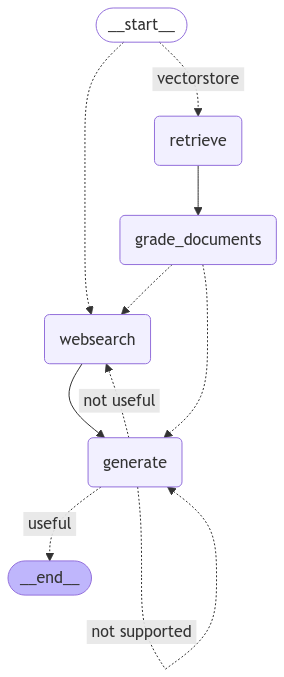

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
output